In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
from scipy.optimize import minimize, NonlinearConstraint, BFGS
import itertools as it
import seaborn as sn

In [2]:
def count_permutationlist(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(len(df)-d+1):
        slice_df = df[i:i+d]
        sort_slice = sorted(slice_df)
        for j in range(d):
            slice_df[slice_df.index(sort_slice[j])] = j
        count_p[perm.index(tuple(slice_df))] += 1
    return count_p
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            #print(slice_df[slice_df==sort_slice.iloc[j]])
            slice_df.replace(slice_df[slice_df==sort_slice.iloc[j]].item(), j, inplace = True)
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [3]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

<AxesSubplot:>

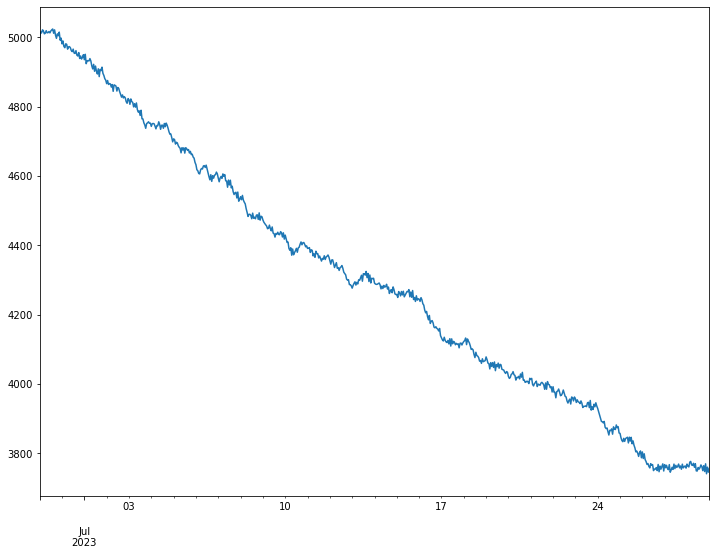

In [4]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
ts = fun(datelist.copy(), 0.4501, 0.5483, 15, 2, 0)
ts.plot(figsize=(12,9))

Проверим скользящее среднее

<AxesSubplot:>

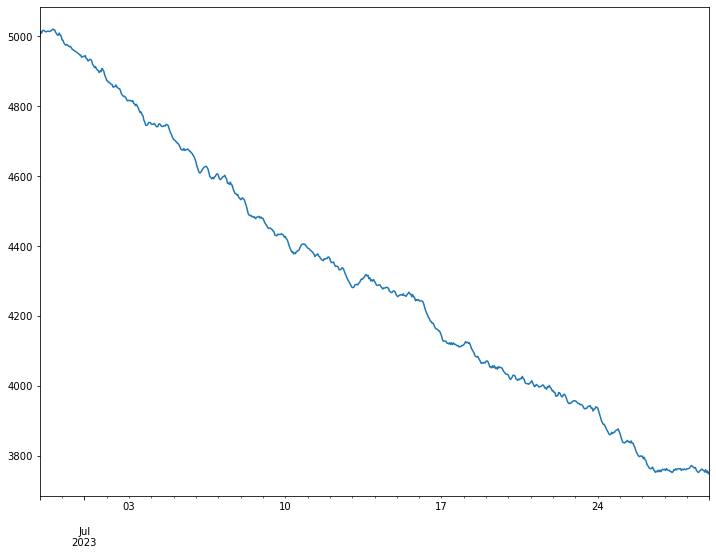

In [5]:
SMA3 = ts.rolling(window=3).mean()
SMA3['29/06/2023 00:00:00'] = 5000.0
SMA3['29/06/2023 01:00:00'] = 5015.0
SMA3.plot(figsize=(12,9))

In [6]:
SMA = []
for i in range(2,11):
    SMAi = ts.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = ts[j]
    SMA.append(SMAi)

In [7]:
datelist['29/06/2023 00:00:00'] = 0.0
datelist['29/06/2023 01:00:00'] = 0.0
noise = fun(datelist.copy(), 0, 0, 15, 0, 0)

Сравним энтропию ряда скользящего среднего с шумом

In [8]:
for d in range(2,11):
    print("len of slice: ", d)
    c = count_permutation(ts.copy(), d)
    c1 = count_permutationlist(noise.copy().tolist(), d)
    print("max entropy: ", math.log2(math.factorial(d)))
    print("noise entropy: ", entropy(c1))
    print("ts entropy: ",entropy(c))
    i = 2
    for mov_avg in SMA:
        Cp = count_permutation(mov_avg.copy(), d)
        print("SMA", i, " entropy: ", entropy(Cp))
        i+=1

len of slice:  2
max entropy:  1.0
noise entropy:  0.9999499058423885
ts entropy:  0.9843082633784581
SMA 2  entropy:  0.966743122866919
SMA 3  entropy:  0.9302917190344344
SMA 4  entropy:  0.8761378030396786
SMA 5  entropy:  0.8761378030396786
SMA 6  entropy:  0.8046070727984818
SMA 7  entropy:  0.7741173113412916
SMA 8  entropy:  0.7219280948873623
SMA 9  entropy:  0.702052187938728
SMA 10  entropy:  0.6564323236169818
len of slice:  3
max entropy:  2.584962500721156
noise entropy:  2.5832728010993087
ts entropy:  2.527770153698466
SMA 2  entropy:  2.3494212018943332
SMA 3  entropy:  2.2682626608177205
SMA 4  entropy:  2.039197234616258
SMA 5  entropy:  2.0002017375399084
SMA 6  entropy:  1.8074109217543612
SMA 7  entropy:  1.7252804326310898
SMA 8  entropy:  1.6044057656800137
SMA 9  entropy:  1.5313057549527573
SMA 10  entropy:  1.4454320093265725
len of slice:  4
max entropy:  4.584962500721156
noise entropy:  4.569577320025402
ts entropy:  4.400337663547087
SMA 2  entropy:  3.951

Сравним энтропию стационарного ряда cо скользящим среднем с энтропией шумового скользящего среднего

<AxesSubplot:>

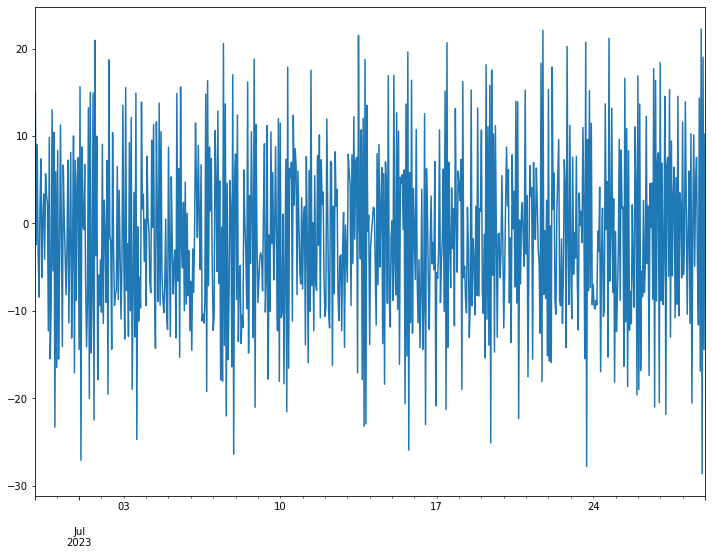

In [9]:
tsdiff = ts.diff(periods=1).dropna()
tsdiff.plot(figsize=(12,9))

In [10]:
SMAdiff = []
for i in range(2,7):
    SMAi = tsdiff.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = tsdiff[j]
    SMAdiff.append(SMAi)
SMAnoise = []
for i in range(2,7):
    SMAi = noise.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = noise[j]
    SMAnoise.append(SMAi)

In [11]:
len(SMAdiff)

5

In [12]:
for d in range(2,11):
    print("len of slice: ", d)
    c1 = count_permutationlist(noise.copy().tolist(), d)
    c2 = count_permutation(tsdiff.copy(), d)
    print("max entropy: ", math.log2(math.factorial(d)))
    print("noise entropy: ", entropy(c1))
    print("tsdiff entropy: ",entropy(c2))
    for i in range(0, 5):
        Cp = count_permutation(SMAdiff[i].copy(), d)
        Cp_noise = count_permutationlist(SMAnoise[i].copy().tolist(), d)
        print("SMAdiff", i+2, " entropy: ", entropy(Cp))
        print("SMAnoise", i+2, " entropy: ", entropy(Cp_noise))

len of slice:  2
max entropy:  1.0
noise entropy:  0.9999499058423885
tsdiff entropy:  0.9995967029206865
SMAdiff 2  entropy:  0.999831154661169
SMAnoise 2  entropy:  0.9998608466987451
SMAdiff 3  entropy:  0.999965115679202
SMAnoise 3  entropy:  0.999799616411146
SMAdiff 4  entropy:  0.999998604637965
SMAnoise 4  entropy:  0.999799616411146
SMAdiff 5  entropy:  0.9997641710419596
SMAnoise 5  entropy:  0.9999109429180594
SMAdiff 6  entropy:  0.9998869727598803
SMAnoise 6  entropy:  0.9995491108252484
len of slice:  3
max entropy:  2.584962500721156
noise entropy:  2.5832728010993087
tsdiff entropy:  2.534680013313748
SMAdiff 2  entropy:  2.5590517823102332
SMAnoise 2  entropy:  2.4953752256166513
SMAdiff 3  entropy:  2.5770512704034303
SMAnoise 3  entropy:  2.480141952773178
SMAdiff 4  entropy:  2.582227621789283
SMAnoise 4  entropy:  2.5114933234539394
SMAdiff 5  entropy:  2.5817203839864553
SMAnoise 5  entropy:  2.523314102829166
SMAdiff 6  entropy:  2.5807564841935813
SMAnoise 6  en

Стационарный ряд не проверяется на прогнозируемость с помощью  энтропии даже со скользящим средним(очевидно).
Проверим как будет влиять количества шума в данных на энтропию ряда, ряда со скользящим средним.

In [13]:
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
list_ts = []
list_ts_ent3 = []
list_ts_ent7 = []
list_SMA3 = []
list_SMA3_ent3 = []
list_SMA3_ent7 = []
list_SMA5 = []
list_SMA5_ent3 = []
list_SMA5_ent7 = []
list_SMA7 = []
list_SMA7_ent3 = []
list_SMA7_ent7 = []
list_rd_walk = []
list_rd_walk_ent3 = []
list_rd_walk_ent7 = []
list_noise = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,100]
max_ent3 = math.log2(math.factorial(3))
max_ent7 = math.log2(math.factorial(7))
noise_ent3 = entropy(count_permutationlist(noise.copy().tolist(), 3))
noise_ent7 = entropy(count_permutationlist(noise.copy().tolist(), 7))
for i in list_noise:
    ts_l = fun(datelist.copy(), 0.4501, 0.5483, i, 2, 0)
    list_ts.append(ts_l)
    list_ts_ent3.append(entropy(count_permutation(ts_l.copy(), 3)))
    list_ts_ent7.append(entropy(count_permutation(ts_l.copy(), 7)))
    SMA_l3 = ts_l.rolling(window=3).mean()
    for j in range (2):
        SMA_l3[j] = ts_l[j]
    list_SMA3.append(SMA_l3)
    list_SMA3_ent3.append(entropy(count_permutation(SMA_l3.copy(), 3)))
    list_SMA3_ent7.append(entropy(count_permutation(SMA_l3.copy(), 7)))
    SMA_l5 = ts_l.rolling(window=5).mean()
    for j in range (4):
        SMA_l5[j] = ts_l[j]
    list_SMA5.append(SMA_l5)
    list_SMA5_ent3.append(entropy(count_permutation(SMA_l5.copy(), 3)))
    list_SMA5_ent7.append(entropy(count_permutation(SMA_l5.copy(), 7)))
    SMA_l7 = ts_l.rolling(window=7).mean()
    for j in range (6):
        SMA_l7[j] = ts_l[j]
    list_SMA7.append(SMA_l7)
    list_SMA7_ent3.append(entropy(count_permutation(SMA_l7.copy(), 3)))
    list_SMA7_ent7.append(entropy(count_permutation(SMA_l7.copy(), 7)))
    rd_walk = fun(datelist.copy(), 1, 0, i, 0, 0)
    list_rd_walk.append(rd_walk)
    list_rd_walk_ent3.append(entropy(count_permutationlist(rd_walk.copy().tolist(), 3)))
    list_rd_walk_ent7.append(entropy(count_permutationlist(rd_walk.copy().tolist(), 7)))

In [14]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[0].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[0].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[0].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[0].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[0].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 0", xaxis_title="Datetime", yaxis_title="Value")

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[5].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[5].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[5].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[5].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[5].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 5", xaxis_title="Datetime", yaxis_title="Value")

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[11].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[11].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[11].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[11].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[11].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 15", xaxis_title="Datetime", yaxis_title="Value")

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[14].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[14].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[14].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[14].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[14].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 30", xaxis_title="Datetime", yaxis_title="Value")

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[-1].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[-1].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[-1].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[-1].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[-1].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 100", xaxis_title="Datetime", yaxis_title="Value")

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent3, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent3, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA5_ent3, name='Entropy of moving mean of 5 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent3, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_ent3, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=[max_ent3]*20, name='Max entropy'))
fig.add_trace(go.Scatter(x=list_noise, y=[noise_ent3]*20, name='Noise entropy'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropy of permutation 3", xaxis_title="Noise", yaxis_title="Entropy")

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent7, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent7, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA5_ent7, name='Entropy of moving mean of 5 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent7, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_ent7, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=[max_ent7]*20, name='Max entropy'))
fig.add_trace(go.Scatter(x=list_noise, y=[noise_ent7]*20, name='Noise entropy'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropyof permutation 7", xaxis_title="Noise", yaxis_title="Entropy")

Посчитаем матрицы корреляций

In [22]:
corr_df_3 = pd.DataFrame(data={'TS':list_ts_ent3,'SMA3':list_SMA3_ent3,'SMA5': list_SMA5_ent3,'SMA7':list_SMA7_ent3,'noise':[noise_ent3]*20, 'RW':list_rd_walk_ent3})
corr_df_7 = pd.DataFrame(data={'TS':list_ts_ent7,'SMA3':list_SMA3_ent7,'SMA5': list_SMA5_ent7,'SMA7':list_SMA7_ent7,'noise':[noise_ent7]*20, 'RW':list_rd_walk_ent7})

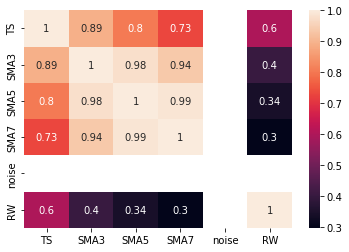

In [23]:
corr3 = corr_df_3.corr()
sn.heatmap(corr3, annot=True)
plt.show()

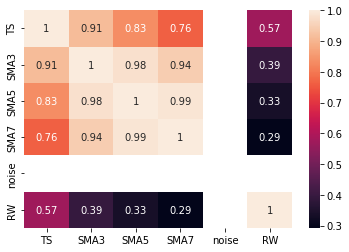

In [24]:
corr7 = corr_df_7.corr()
sn.heatmap(corr7, annot=True)
plt.show()

In [25]:
list_rd_walk_ent3

[0.0,
 2.509197609154224,
 2.5068156293929365,
 2.4732449551520963,
 2.4821674136363736,
 2.4754331864011276,
 2.4854978346118908,
 2.4634835543080165,
 2.505325004415111,
 2.501874378483616,
 2.5113977868794404,
 2.505968264126564,
 2.4821753948675473,
 2.516806519527154,
 2.509543134885087,
 2.5125608050839023,
 2.4861123864937174,
 2.475653707904904,
 2.4818306744351935,
 2.494471477898762]

In [26]:
list_rd_walk_ent7

[0.0,
 8.784584718386109,
 8.842113164507643,
 8.58543622540015,
 8.732073206352338,
 8.63770641260691,
 8.73740847174239,
 8.704677465728762,
 8.738156692745855,
 8.845976049343257,
 8.69695269852338,
 8.769694610408951,
 8.731782006697461,
 8.871443720642558,
 8.842086931789229,
 8.833834995383784,
 8.599372976468258,
 8.5935823648609,
 8.743084026274058,
 8.777861560167114]

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk_ent3, name='Entropy3 of random walk'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk_ent7, name='Entropy7 of random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropyof permutation 7", xaxis_title="Noise", yaxis_title="Entropy")

In [31]:
list_rd_walk_SMA3 = []
list_rd_walk_SMA7 = []
list_rd_walk_SMA3_ent3 = []
list_rd_walk_SMA3_ent7 = []
list_rd_walk_SMA7_ent3 = []
list_rd_walk_SMA7_ent7 = []
for rd in list_rd_walk:
    temp3 = rd.rolling(window=3).mean()
    temp7 = rd.rolling(window=7).mean()
    list_rd_walk_SMA3.append(temp3)
    list_rd_walk_SMA7.append(temp7)
    list_rd_walk_SMA3_ent3.append(entropy(count_permutationlist(temp3.copy().tolist(), 3)))
    list_rd_walk_SMA3_ent7.append(entropy(count_permutationlist(temp3.copy().tolist(), 7)))
    list_rd_walk_SMA7_ent3.append(entropy(count_permutationlist(temp7.copy().tolist(), 3)))
    list_rd_walk_SMA7_ent7.append(entropy(count_permutationlist(temp7.copy().tolist(), 7)))

In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent3, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent3, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent3, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_ent3, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_SMA3_ent3, name='Entropy of moving mean random walk of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_SMA7_ent3, name='Entropy of moving mean random walk of 7 average'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropy of permutation 3", xaxis_title="Noise", yaxis_title="Entropy")

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent7, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent7, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent7, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_ent7, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_SMA3_ent7, name='Entropy of moving mean random walk of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_rd_walk_SMA7_ent7, name='Entropy of moving mean random walk of 7 average'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropy of permutation 7", xaxis_title="Noise", yaxis_title="Entropy")

Получаем ситуацию, где скользящее среднее уменьшает энтропию любого ряда, в том числе и непрогнозируемого.

In [38]:
corr_SMA_3 = pd.DataFrame(data={'SMA3':list_SMA3_ent3,'SMA7':list_SMA7_ent3,'RW_SMA3':list_rd_walk_SMA3_ent3, 'RW_SMA7':list_rd_walk_SMA3_ent7})
corr_SMA_7 = pd.DataFrame(data={'SMA3':list_SMA3_ent7,'SMA7':list_SMA7_ent7,'RW_SMA3':list_rd_walk_SMA3_ent7, 'RW_SMA7':list_rd_walk_SMA7_ent7})

In [40]:
corr3 = corr_SMA_3.corr()
sn.heatmap(corr3, annot=True)
plt.show()

In [41]:
corr7 = corr_SMA_7.corr()
sn.heatmap(corr7, annot=True)
plt.show()